In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
def generate_dataset(n, alpha):
    dataset = {'0': [], '1': []}
    for _ in range(int(alpha*n)):
        dataset['0'].append(np.random.binomial(p=mean_arms[0], n=1))
    for _ in range(n - int(alpha*n)):
        dataset['1'].append(np.random.binomial(p=mean_arms[1], n=1))
    return dataset

In [61]:
regret_data = []
num_iters = 10
T = 50000
n = 20
delta = .1
alpha = .5
mean_arms = [.5, .5-delta]

simple_done = False
online_done = False

online_use_all_data_count = 0.0

for i in range(num_iters):
    dataset = generate_dataset(n, alpha)
#     print(f'Dataset: {dataset}')
    simple_mean = np.asarray([max(0.0,np.mean(dataset['0'])), max(0.0,np.mean(dataset['1']))])
    simple_select = np.asarray([len(dataset['0']), len(dataset['1'])])
#     print(f'Starting estimates, simple: {simple_mean}, {simple_select}')
    online_mean = np.asarray([0.0,0.0])
    online_select = np.asarray([0,0])
    online_data_index = np.asarray([0,0])
    online_regret_index = 0
    simple_regret = 0
    online_regret = 0
    
    for t in range(T+n):
        
        if not simple_done:
            simple_ucb = np.asarray([simple_mean[i] + (np.sqrt(np.log(1+t)) / np.sqrt(simple_select[i])) \
                                         if simple_select[i] > 0 else np.inf for i in range(2)])
            # print(f'Simple UCB: {simple_ucb}')
            simple_arm = np.argmax(simple_ucb)
            simple_regret += mean_arms[0] - mean_arms[simple_arm]
            regret_data.append({'Algo': 'Simple', 'Iter': i, 't': t, 'Regret': simple_regret})
            simple_obs = np.random.binomial(p=mean_arms[simple_arm], n = 1)
            simple_mean[simple_arm] = (simple_mean[simple_arm]*simple_select[simple_arm] + simple_obs) / (simple_select[simple_arm]+1)
            simple_select[simple_arm] += 1
            
            if t == T - 1:
                simple_done = True

        if not online_done:
            online_ucb = np.asarray([online_mean[i] + (np.sqrt(np.log(online_regret_index+1)) / np.sqrt(online_select[i])) \
                                        if online_select[i] > 0 else np.inf for i in range(2)])
            online_arm = np.argmax(online_ucb)
            if online_data_index[online_arm] < len(dataset[str(online_arm)]):
                online_obs = dataset[str(online_arm)][online_data_index[online_arm]]
                online_mean[online_arm] = (online_select[online_arm]*online_mean[online_arm] + online_obs) / (online_select[online_arm]+1)
                online_select[online_arm] += 1
                online_data_index[online_arm] += 1

            else:
                online_obs = np.random.binomial(p=mean_arms[simple_arm], n = 1)
                online_regret += mean_arms[0] - mean_arms[simple_arm]
                regret_data.append({'Algo': 'Online', 'Iter': i, 't': online_regret_index, 'Regret': online_regret})

                online_mean[online_arm] = (online_select[online_arm]*online_mean[online_arm] + online_obs) / online_select[online_arm]
                online_select[online_arm] += 1
                online_regret_index += 1
                
                if online_regret_index == T - 1:
                    online_done = True
            
    if online_data_index[0] == len(dataset['0']) and online_data_index[1] == len(dataset['1']):
        online_use_all_data_count += 1
print(f'Percentage of trial online algorithm uses entire dataset: {online_use_all_data_count / num_iters}')

Percentage of trial online algorithm uses entire dataset: 0.0


<AxesSubplot:xlabel='t', ylabel='Regret'>

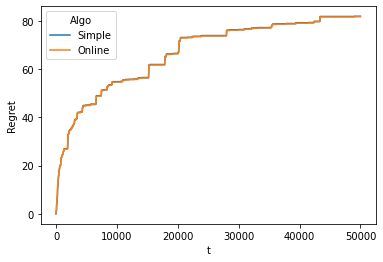

In [62]:
df = pd.DataFrame(regret_data)
sns.lineplot(data = df, x="t", y="Regret", hue="Algo", ci=None)